In [1]:
import os
import json
from pymongo import MongoClient
import pandas as pd
from pprint import pprint
from collections import Counter
from itertools import combinations
import seaborn as sns

In [2]:
SynPro_client = MongoClient(
    os.getenv('SYNPRO_HOST'),
    username=os.getenv('SYNPRO_USER'),
    password=os.getenv('SYNPRO_PSWD'),
    authSource=os.getenv('SYNPRO_DB'),
    authMechanism=os.getenv('SYNPRO_MECH')
)

FullText_client = MongoClient(
    os.getenv('FULLTEXT_HOST'),
    username=os.getenv('FULLTEXT_USER'),
    password=os.getenv('FULLTEXT_PSWD'),
    authSource=os.getenv('FULLTEXT_DB'),
    authMechanism=os.getenv('FULLTEXT_MECH')
)

SynPro_db = SynPro_client[os.getenv('SYNPRO_DB')]
FullText_db = FullText_client[os.getenv('FULLTEXT_DB')]

In [3]:
with open('./data/old_data/bfo_db_dois.json', 'r') as fp:
    bfo_db_dois = json.load(fp)
    
tm_data = pd.read_csv('./data/bfo_lit_df_master_20221019.csv')
    
unique_bfo_db_dois = []
for i, doi in enumerate(bfo_db_dois):
    if doi.upper() not in bfo_db_dois[:i] + bfo_db_dois[i+1:]:
        unique_bfo_db_dois.append(doi)

In [4]:
db_stats = []

for i, doi in enumerate(unique_bfo_db_dois):
    article_stats = {
        'meta' : {
            'DOI' : doi
        },
        'synth_method' : {
            'solid_state_ceramic_synthesis' : False,
            'sol_gel_ceramic_synthesis' : False,
            'hydrothermal_ceramic_synthesis' : False,
            'precipitation_ceramic_synthesis' : False,
            'something_else' : False
        }
    }
    
    db_paper_metadata = FullText_db.Paper_Metadata.find_one({'DOI' : doi})
    paragraphs = [para for para in SynPro_db.Paragraphs.find({'DOI' : doi})]
    paragraphs_meta = [para for para in SynPro_db.Paragraphs_Meta.find({'DOI' : doi})]
    
    for para in paragraphs_meta:
        if 'classification' in para.keys():
            if para['classification']:
                article_stats['synth_method'][para['classification']] = True
            
    db_stats.append(article_stats)
    print(f'Article retrieval progress: {i}/{len(unique_bfo_db_dois)}', end='\r')

In [5]:
sol_gel_ct = len([pub for pub in db_stats if pub['synth_method']['sol_gel_ceramic_synthesis']])
solid_state_ct = len([pub for pub in db_stats if pub['synth_method']['solid_state_ceramic_synthesis']])
hydrothermal_ct = len([pub for pub in db_stats if pub['synth_method']['hydrothermal_ceramic_synthesis']])
precipitation_ct = len([pub for pub in db_stats if pub['synth_method']['precipitation_ceramic_synthesis']])

print(sol_gel_ct)
print(solid_state_ct)
print(hydrothermal_ct)
print(precipitation_ct)

328
241
84
38


In [6]:
solgel_bfo_dois = [pub['meta']['DOI'] for pub in db_stats if pub['synth_method']['sol_gel_ceramic_synthesis']]

ct = 0
missing = []
for doi in solgel_bfo_dois:
    if doi not in tm_data['doi'].to_list():
        ct += 1
        missing.append(doi)
        
print(ct)
pprint(missing)

269
['10.1016/j.apsusc.2012.04.166',
 '10.1016/j.jmmm.2015.05.066',
 '10.1007/s12648-014-0546-y',
 '10.1016/j.ceramint.2012.06.014',
 '10.1016/j.physc.2018.02.052',
 '10.1016/j.materresbull.2014.06.022',
 '10.1063/1.3040010',
 '10.1111/j.1551-2916.2007.01937.x',
 '10.1111/j.1551-2916.2012.05411.x',
 '10.1016/j.cej.2016.11.016',
 '10.1016/j.matlet.2008.05.051',
 '10.1007/s11051-012-1310-x',
 '10.1016/j.nanoso.2016.08.001',
 '10.1016/j.jcrysgro.2016.09.054',
 '10.1016/j.materresbull.2019.110543',
 '10.1016/j.apsusc.2017.04.210',
 '10.1039/c1jm13072b',
 '10.1038/s41598-018-28557-w',
 '10.1007/s00339-015-9454-z',
 '10.1007/s10971-014-3477-3',
 '10.1063/1.4895836',
 '10.1016/j.jeurceramsoc.2009.05.018',
 '10.1007/s10854-014-1820-7',
 '10.1016/j.solidstatesciences.2011.07.008',
 '10.1007/s10854-017-8379-z',
 '10.1111/j.1551-2916.2007.01952.x',
 '10.1016/j.matchemphys.2019.02.059',
 '10.1016/j.matlet.2005.07.050',
 '10.1007/s10854-017-7654-3',
 '10.1007/s10854-018-9286-7',
 '10.1016/j.ssc.201

In [7]:
nanoparticle_papers = [
    '10.1016/j.jmmm.2015.05.066',
    '10.1016/j.ceramint.2012.06.014',
    '10.1016/j.physc.2018.02.052'
]

In [8]:
# missing annealing temperature: 
# missing annealing time

# missing Bi:Fe ratio: 57
# missing precursor concentration: 

In [9]:
pd.set_option('display.max_colwidth', None)

chem_counter = Counter([
    y for x in tm_data[
        ['solvent1', 
         'solvent2', 
         'chelating_agent1', 
         'chelating_agent2', 
         'dehydrating_agent1', 
         'dehydrating_agent2', 
         'surfactant']
    ].values for y in combinations(x, 7)])

chem_combo_df = pd.DataFrame({'Combo': list(chem_counter.keys()), 'Qty' : list(chem_counter.values())}).sort_values(by='Qty', ascending=False)

display(chem_combo_df)

,Combo,Qty
4,"(2_methoxyethanol, nan, nan, nan, acetic_anhydride, nan, nan)",65
10,"(2_methoxyethanol, nan, acetic_acid, nan, nan, nan, nan)",38
1,"(2_methoxyethanol, nan, acetic_acid, nan, acetic_acid_glacial, nan, nan)",27
8,"(2_methoxyethanol, nan, citric_acid, nan, nan, nan, nan)",27
0,"(2_methoxyethanol, nan, nan, nan, nan, nan, nan)",21
3,"(2_methoxyethanol, nan, nan, nan, acetic_anhydride, nan, ethanolamine)",12
12,"(nan, nan, acetic_acid, acetylacetone, nan, nan, nan)",12
41,"(ethylene_glycol, nan, citric_acid, nitric_acid, nan, nan, nan)",12
37,"(2_methoxyethanol, nan, nan, nan, acetic_acid_glacial, nan, nan)",12
9,"(nan, ethylene_glycol, nan, nan, nan, nan, nan)",11


In [10]:
doi_counts = tm_data.groupby('doi')['doi'].count()

In [11]:
lit_features_df = pd.read_csv('./data/bfo_lit_df_viz_20221019.csv').drop(['Unnamed: 0', 'recipe_id', 'impurity_code'], axis=1)

In [12]:
lit_features_df_norm_col = (lit_features_df - lit_features_df.mean()) / lit_features_df.std()
display(lit_features_df_norm_col)

,bi_fe_ratio,separate_hydrolysis,precursor_concentration,pH,stirring_time_hr,stirring_temp_degC,age_days,age_temp_degC,low_coating_time_sec,low_coating_rpm,...,chem_pca-c21,chem_pca-c22,chem_pca-c23,chem_pca-c24,chem_pca-c25,chem_pca-c26,chem_pca-c27,chem_pca-c28,chem_pca-c29,chem_pca-c30
0,1.145202,-0.275184,-0.475514,NaN,-0.074598,0.001734,0.63808,-0.282027,2.061478,-1.217831,...,0.810860,-1.589227,-0.752456,-0.912960,0.699632,-0.192174,-1.442443,0.991184,-0.320686,-0.897696
1,-0.163204,-0.275184,-0.475514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.258327,1.071578,1.023317,0.013452,0.607944,-0.911822,0.462401,-0.832381,0.482209,-0.049286
2,1.145202,-0.275184,NaN,NaN,-0.657865,-0.696187,NaN,NaN,NaN,NaN,...,-0.007042,-1.086282,-0.941481,-0.829176,0.109065,0.062832,-0.747952,2.376139,0.703154,-0.143732
3,1.145202,-0.275184,NaN,NaN,-0.657865,-0.696187,NaN,NaN,NaN,NaN,...,-0.007042,-1.086282,-0.941481,-0.829176,0.109065,0.062832,-0.747952,2.376139,0.703154,-0.143732
4,1.145202,-0.275184,NaN,NaN,-0.657865,-0.696187,NaN,NaN,NaN,NaN,...,-0.007042,-1.086282,-0.941481,-0.829176,0.109065,0.062832,-0.747952,2.376139,0.703154,-0.143732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,NaN,-0.275184,-0.475514,NaN,NaN,NaN,NaN,-0.282027,-0.812616,0.355981,...,-1.475248,-0.347949,-1.480559,-0.153189,-1.809215,0.225788,-1.045304,1.454910,-0.211700,0.298427
336,NaN,-0.275184,-0.475514,NaN,NaN,NaN,NaN,-0.282027,-0.812616,0.355981,...,-1.475248,-0.347949,-1.480559,-0.153189,-1.809215,0.225788,-1.045304,1.454910,-0.211700,0.298427
337,NaN,-0.275184,-0.475514,NaN,NaN,NaN,NaN,-0.282027,-0.812616,0.355981,...,-1.475248,-0.347949,-1.480559,-0.153189,-1.809215,0.225788,-1.045304,1.454910,-0.211700,0.298427
338,NaN,-0.275184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.810860,-1.589227,-0.752456,-0.912960,0.699632,-0.192174,-1.442443,0.991184,-0.320686,-0.897696


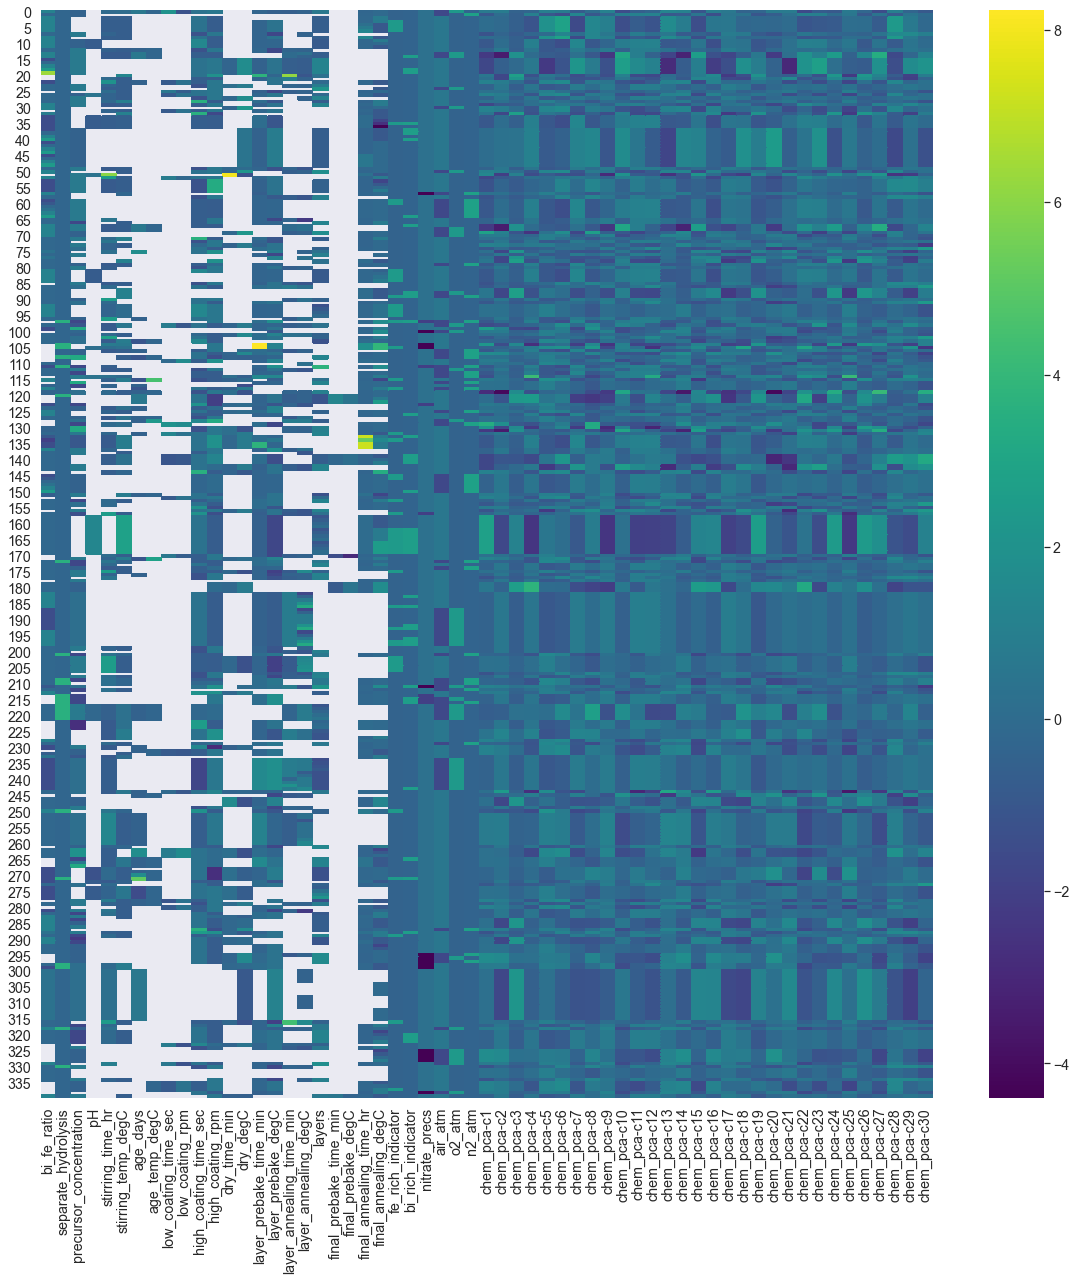

In [13]:
sns.set(rc={'figure.figsize':(20,20)}, font_scale=1.3)
fig = sns.heatmap(
    lit_features_df_norm_col, 
    cmap='viridis'
)
fig.get_figure().savefig(
    '/Users/kevcruse96/Desktop/D2S2/synthesis_imputation/bfo_thinfilmsynth_heatmap',
    bbox_inches='tight'
)

In [14]:
from sklearn.impute import KNNImputer

np_data = lit_features_df.to_numpy()
imputer = KNNImputer(n_neighbors=2)
imputed_df = pd.DataFrame(imputer.fit_transform(np_data))

In [15]:
display(lit_features_df)
display(imputed_df)

,bi_fe_ratio,separate_hydrolysis,precursor_concentration,pH,stirring_time_hr,stirring_temp_degC,age_days,age_temp_degC,low_coating_time_sec,low_coating_rpm,...,chem_pca-c21,chem_pca-c22,chem_pca-c23,chem_pca-c24,chem_pca-c25,chem_pca-c26,chem_pca-c27,chem_pca-c28,chem_pca-c29,chem_pca-c30
0,1.10,0,0.2,NaN,3.0,50.0,2.0,25.0,15.0,400.0,...,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295
1,1.05,0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.378029,1.309943,3.122355,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376
2,1.10,0,NaN,NaN,1.0,25.0,NaN,NaN,NaN,NaN,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
3,1.10,0,NaN,NaN,1.0,25.0,NaN,NaN,NaN,NaN,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
4,1.10,0,NaN,NaN,1.0,25.0,NaN,NaN,NaN,NaN,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,NaN,0,0.2,NaN,NaN,NaN,NaN,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
336,NaN,0,0.2,NaN,NaN,NaN,NaN,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
337,NaN,0,0.2,NaN,NaN,NaN,NaN,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
338,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.100,0.0,0.200,1.50,3.000000,50.0,2.000000,25.0,15.0,400.0,...,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295
1,1.050,0.0,0.200,1.50,0.500000,25.0,1.000000,25.0,9.5,500.0,...,-0.378029,1.309943,3.122355,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376
2,1.100,0.0,0.250,1.50,1.000000,25.0,0.750000,25.0,9.5,450.0,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
3,1.100,0.0,0.225,1.50,1.000000,25.0,1.250000,25.0,9.5,450.0,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
4,1.100,0.0,0.225,3.00,1.000000,25.0,2.000000,25.0,9.5,450.0,...,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1.025,0.0,0.200,3.05,6.000000,25.0,1.000000,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
336,1.100,0.0,0.200,1.50,1.250000,42.5,1.000000,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
337,1.050,0.0,0.200,1.50,0.500000,65.0,0.541665,25.0,3.0,1000.0,...,-2.959785,-0.094804,-0.454557,1.791095,-1.013490,0.305628,1.525695,1.754914,0.468679,2.761790
338,1.075,0.0,0.180,1.50,0.583333,37.5,0.750000,25.0,9.5,450.0,...,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295


In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{helvet}')

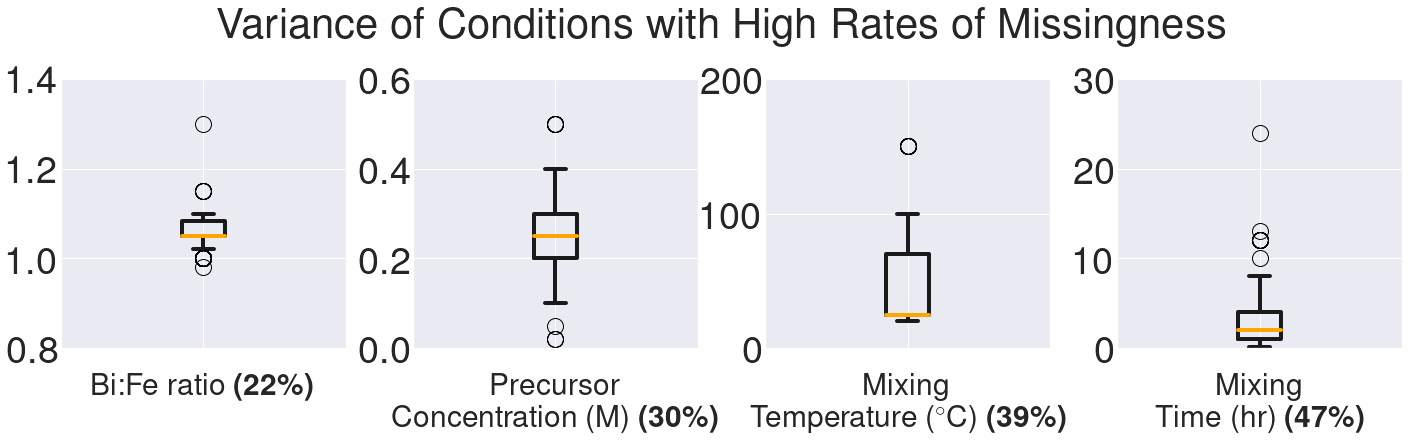

In [23]:
fig, (biferatio, precconc, mixtemp, mixtime) = plt.subplots(
    1, 4, 
    figsize=(20, 5),
#     gridspec_kw={'width_ratios': [1, 0.5, 0.5, 0.5]}
)
fig.tight_layout(pad=2.0)

boxprops = dict(linestyle='-', linewidth=4, color='k')
whiskerprops = dict(linestyle='-', linewidth=4, color='k')
capprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='orange')
flierprops = dict(markersize=16, color='k')

biferatio.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
precconc.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
mixtemp.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
mixtime.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

biferatio.boxplot(
    lit_features_df['bi_fe_ratio'].dropna().tolist(),
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    flierprops=flierprops
)
precconc.boxplot(
    lit_features_df['precursor_concentration'].dropna().tolist(),
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    flierprops=flierprops
)
mixtemp.boxplot(
    lit_features_df['stirring_temp_degC'].dropna().tolist(),
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    flierprops=flierprops
)
mixtime.boxplot(
    lit_features_df['stirring_time_hr'].dropna().tolist(),
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    flierprops=flierprops
)

plt.draw()

biferatio.set_xticklabels([r'Bi:Fe ratio \textbf{(22\%)}'])
precconc.set_xticklabels(['Precursor\n' + r'Concentration (M) \textbf{(30\%)}'])
mixtemp.set_xticklabels(['Mixing\n' + r'Temperature ($^{\circ}$C) \textbf{(39\%)}'])
mixtime.set_xticklabels(['Mixing\n' + r'Time (hr) \textbf{(47\%)}'])

biferatio.tick_params(axis='x', labelsize=30, pad=18)
precconc.tick_params(axis='x', labelsize=30, pad=18)
mixtemp.tick_params(axis='x', labelsize=30, pad=18)
mixtime.tick_params(axis='x', labelsize=30, pad=18)

biferatio.tick_params(axis='y', labelsize=38, pad=-5)
precconc.tick_params(axis='y', labelsize=38, pad=-5)
mixtemp.tick_params(axis='y', labelsize=38, pad=-5)
mixtime.tick_params(axis='y', labelsize=38, pad=-5)

biferatio.set_ylim(0.8, 1.4)
precconc.set_ylim(0, 0.6)
mixtemp.set_ylim(0, 200)
mixtime.set_ylim(0, 30)

fig.suptitle('Variance of Conditions with High Rates of Missingness', fontsize=42, y=1.1)

plt.savefig('./figures/202305_missing_condition_spreads.png', bbox_inches='tight')